In [1]:
import json
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pickle

from collections import namedtuple, defaultdict, Counter
from itertools import groupby, chain, count
from operator import itemgetter
from scipy.spatial.distance import cdist
from tqdm import tqdm

from matplotlib import rc

In [2]:
DATA_DIR = '/home/mikhail/bioinformatics/data/fragment_data_2'

In [3]:
FragmentData = namedtuple('FragmentData', 'type sequence length')
FragmentPairData = namedtuple('FragmentPairData', 'lefts rights relation fragment_distance sequence_distance')

FragmentPair = namedtuple('FragmentPair', 'data distance pdb_id chain_id left right')

In [4]:
def generate_data():
    for i in count():
        fpath = os.path.join(DATA_DIR, 'batch_{}'.format(i))
        
        if os.path.exists(fpath):
            with open(fpath, 'rb') as infile:
                yield from pickle.load(infile)
        else:
            break

Для пар фрагментов соберем ``distance`` -- физическое расстояние между фрагментами, ``sequence_distance`` -- расстояние между фрагментами по сиквенсу.

In [5]:
distance = []
sequence_distance = []
chain_label = []

for fragment_pair in tqdm(generate_data()):
    distance.append(fragment_pair.distance)
    sequence_distance.append(fragment_pair.data.sequence_distance)
    chain_label.append('{}_{}'.format(fragment_pair.pdb_id, fragment_pair.chain_id))

857270it [00:33, 25404.37it/s]


In [9]:
distance = np.array(distance)
sequence_distance = np.array(sequence_distance)
chain_label = np.array(chain_label)

In [10]:
target = distance < 8

Нарисуем точки (distance, sequence_distance).

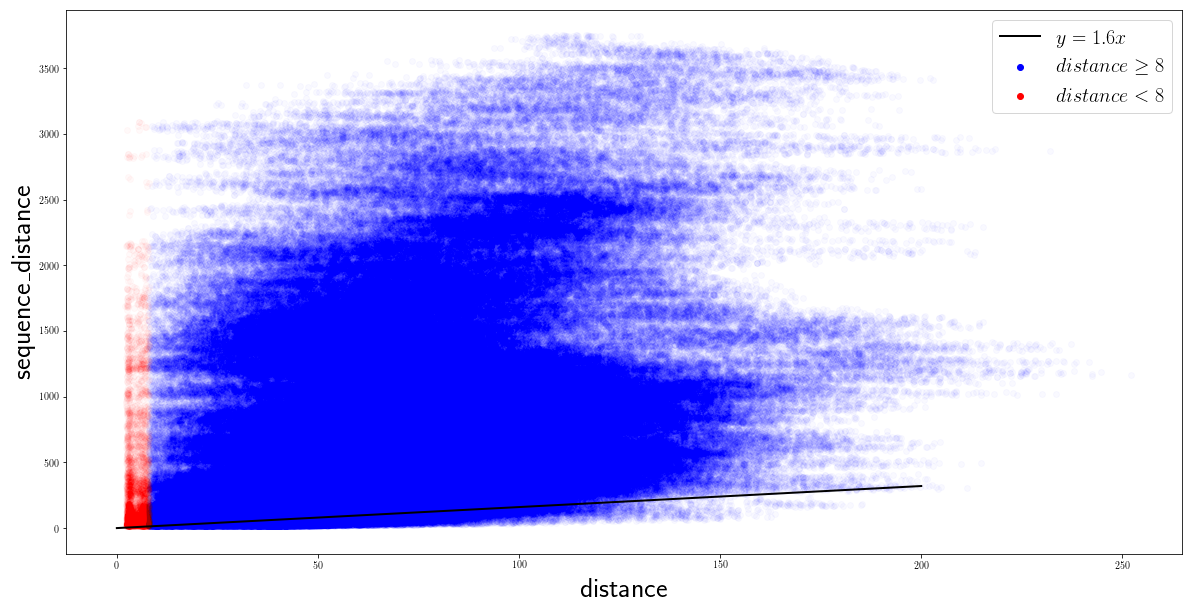

In [8]:
plt.figure(figsize=(20, 10))

plt.xlabel('distance', fontsize=28)
plt.ylabel('sequence\_distance', fontsize=28)

plt.scatter(distance[~target], sequence_distance[~target], alpha=0.01, color='b', label='$distance \ge 8$')
plt.scatter(distance[target], sequence_distance[target], alpha=0.01, color='r', label='$distance < 8$')
plt.plot([0, 200], [0, 1.6 * 200], lw=2, color='k', label='$y = 1.6x$')

legend = plt.legend(fontsize=20)
for lh in legend.legendHandles: 
    lh.set_alpha(1)

Итак, видим корреляцию. Странное число 1.6 в легенде -- это среднее расстояние между соседними нуклеотидами в цепочке.

Построим, как раньше, зависимость количества positive пар фрагментов в цепочке от количества фрагментов в цепочке 

In [7]:
with open('chain_lengths.pickle', 'rb') as infile:
    chain_lengths = pickle.load(infile)

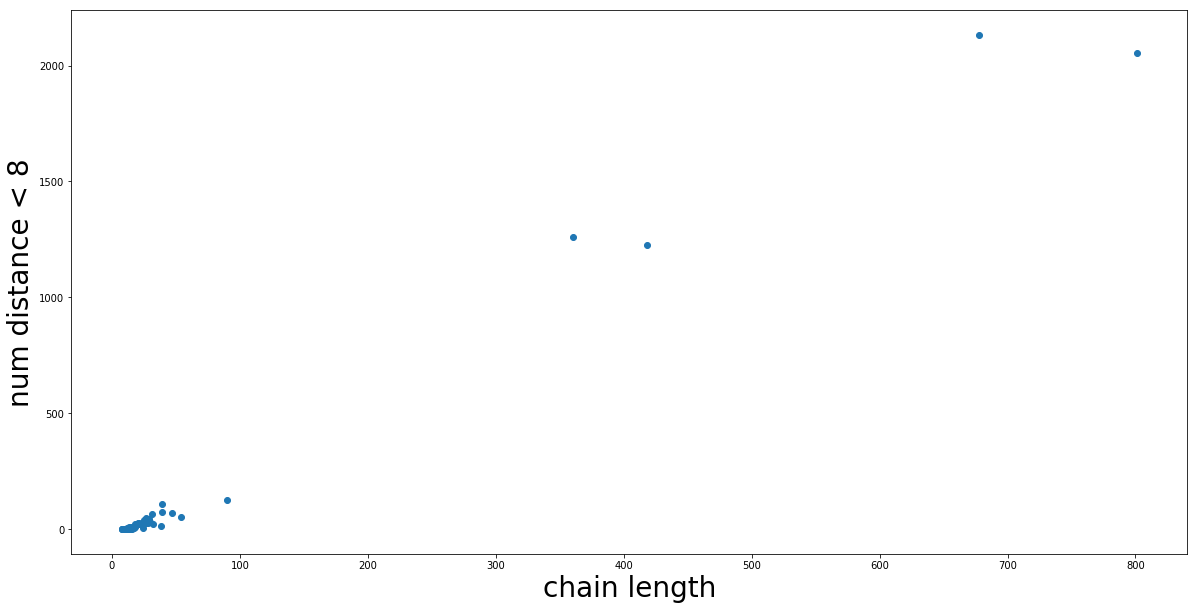

In [12]:
chain_lengths_list = []
num_positives_list = []

for cl, chain_length in chain_lengths.items():
    chain_lengths_list.append(chain_length)
    num_positives_list.append(target[chain_label == cl].sum())

plt.figure(figsize=(20, 10))

plt.xlabel('chain length', fontsize=28)
plt.ylabel('num distance < 8', fontsize=28)

plt.scatter(chain_lengths_list, num_positives_list)

plt.savefig('chains.png')

2 пары цепочек сверху -- это (4y4o_1a, 6qzp_S2) и (4y4o_2A, 6qzp_L5)

Теперь построим 2 графика, где по оси $x$ отложим расстояние по сиквенсу, а по оси $y$ для одного графика -- общее колличество пар в выборке, таких что расстояние по сиквенсу для них не превосходит $x$, для другого графика -- количество positive (то есть $distance < 8$) пар в выборке, таких что расстояние по сиквенсу для них не превосходит $x$

In [11]:
def make_locality_curve(sequence_distance, target):
    sequence_thresholds = np.sort(np.unique(sequence_distance))
    
    num_positive = []
    overall_num = []

    for threshold in tqdm(sequence_thresholds):
        mask = sequence_distance <= threshold
        overall_num.append(mask.sum())
        num_positive.append(target[mask].sum())
    
    plt.figure(figsize=(20, 10))

    plt.xlabel('sequence distance', fontsize=28)

    plt.ylabel('num positive', color='b', fontsize=28)
    plt.plot(sequence_thresholds, num_positive, color='b')

    ax = plt.twinx()
    ax.set_ylabel('num overall', color='r', fontsize=28)
    ax.plot(sequence_thresholds, overall_num, color='r')

100%|██████████| 3729/3729 [00:07<00:00, 505.84it/s]


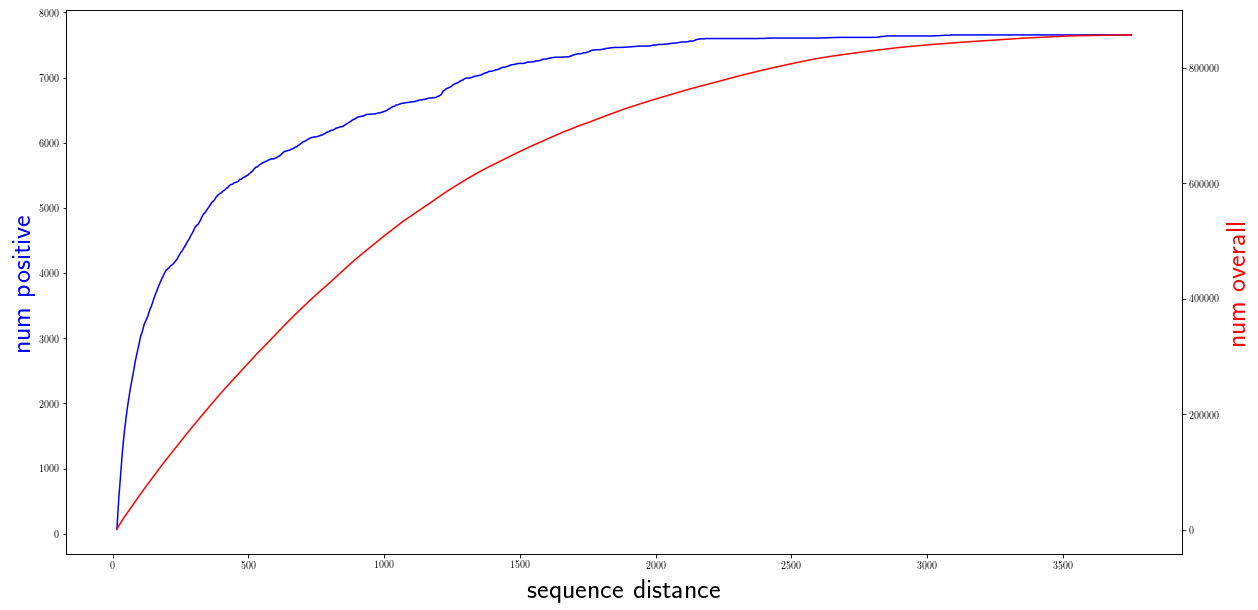

In [12]:
make_locality_curve(sequence_distance, target)

Теперь то же самое, только отдельно для случая коротких и длинных цепочек.

In [13]:
long_mask = np.array([cl.split('_')[0] in ['4y4o', '6qzp'] for cl in chain_label])

100%|██████████| 3729/3729 [00:07<00:00, 528.57it/s]


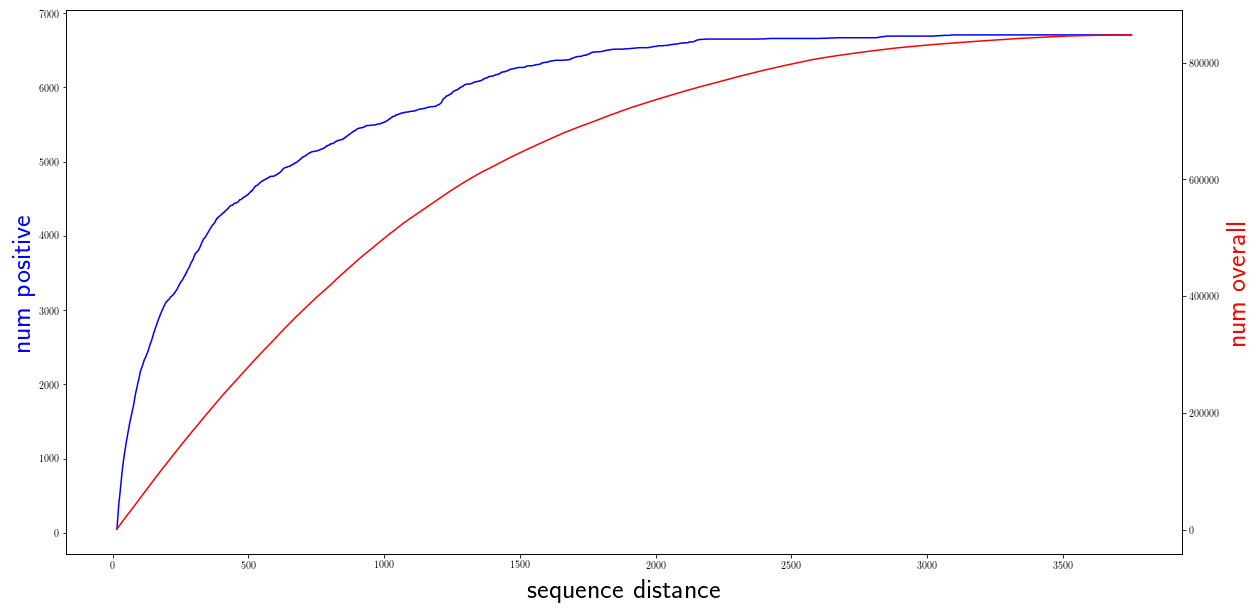

In [14]:
make_locality_curve(sequence_distance[long_mask], target[long_mask])

100%|██████████| 316/316 [00:00<00:00, 15263.08it/s]


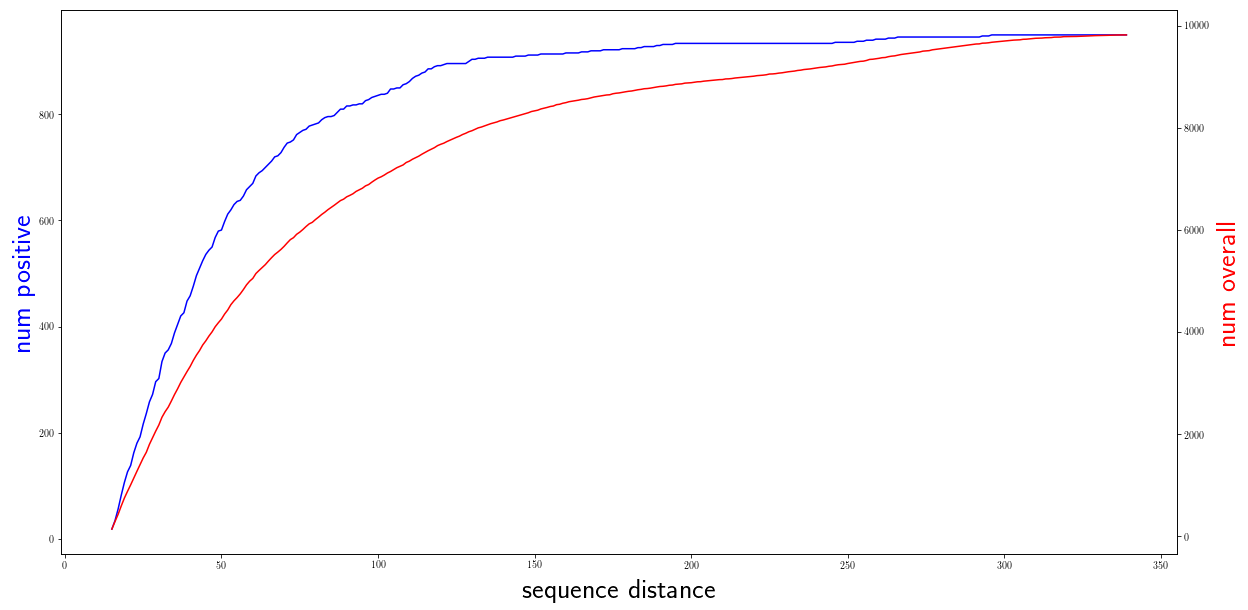

In [15]:
make_locality_curve(sequence_distance[~long_mask], target[~long_mask])

Ожидаемо получили, что различать локальные и не локальные спаривания имеет смысл только в длинных цепочках.

Посмотрим ещё, как positive распределен между длинными/короткими цепочками

In [16]:
long_chains = ['4y4o_1a', '6qzp_S2', '4y4o_2A', '6qzp_L5']
chain_positives = {ch: target[chain_label == ch].sum() for ch in long_chains}

chain_positives['short'] = target[~long_mask].sum()

chain_positives

{'4y4o_1a': 1258,
 '6qzp_S2': 1224,
 '4y4o_2A': 2132,
 '6qzp_L5': 2056,
 'short': 950}

In [17]:
chain_negatives = {ch: (chain_label == ch).sum() - target[chain_label == ch].sum() for ch in long_chains}

chain_negatives['short'] = (~long_mask).sum() - target[~long_mask].sum()

chain_negatives

{'4y4o_1a': 99880,
 '6qzp_S2': 113714,
 '4y4o_2A': 274552,
 '6qzp_L5': 351796,
 'short': 8866}